In [1]:
!pip install scikit-optimize


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss

# Tree Ensemble Examples
Below we illustrate tree ensemble models, and hyperparameter tuning.

**Mounting the Google Drive**

This assumes you have previously downloaded the PiML GitHub repository, and are running this notebook from its location in that repository.  Otherwise, you may need to adjust the path to the data as needed.  If you are working in a local environment, this is not necessary.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd 'gdrive/My Drive/'

/content/gdrive/My Drive


## Read and prepare the data
Read in the Taiwan credit data from the PiML repository.

In [5]:
data = pd.read_csv("piml/PiML-Toolbox/datasets/TaiwanCredit.csv")

In [6]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,FlagDefault
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.779867,1.519567,35.485500,0.167233,0.118367,0.106133,0.069200,0.036867,...,3.670062,3.599323,3.507501,2.879374,2.850124,2.728754,2.639519,2.619748,2.576596,0.221200
std,129747.661567,0.489129,0.728486,0.524175,9.217904,0.931323,0.965844,0.950876,0.911613,0.864561,...,1.733904,1.762540,1.833062,1.411589,1.423945,1.454766,1.475124,1.495708,1.532231,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-5.230452,-4.910277,-5.530973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.366936,3.246499,3.099335,3.000434,2.921166,2.592177,2.472756,2.403976,2.074631,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.279964,4.257811,4.232285,3.322426,3.303196,3.255514,3.176381,3.176381,3.176381,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.736452,4.700630,4.691958,3.699578,3.699057,3.653791,3.603604,3.605574,3.602169,0.000000
max,1000000.000000,2.000000,3.000000,2.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,5.950164,5.967160,5.983024,5.941289,6.226409,5.952328,5.793092,5.629950,5.723182,1.000000


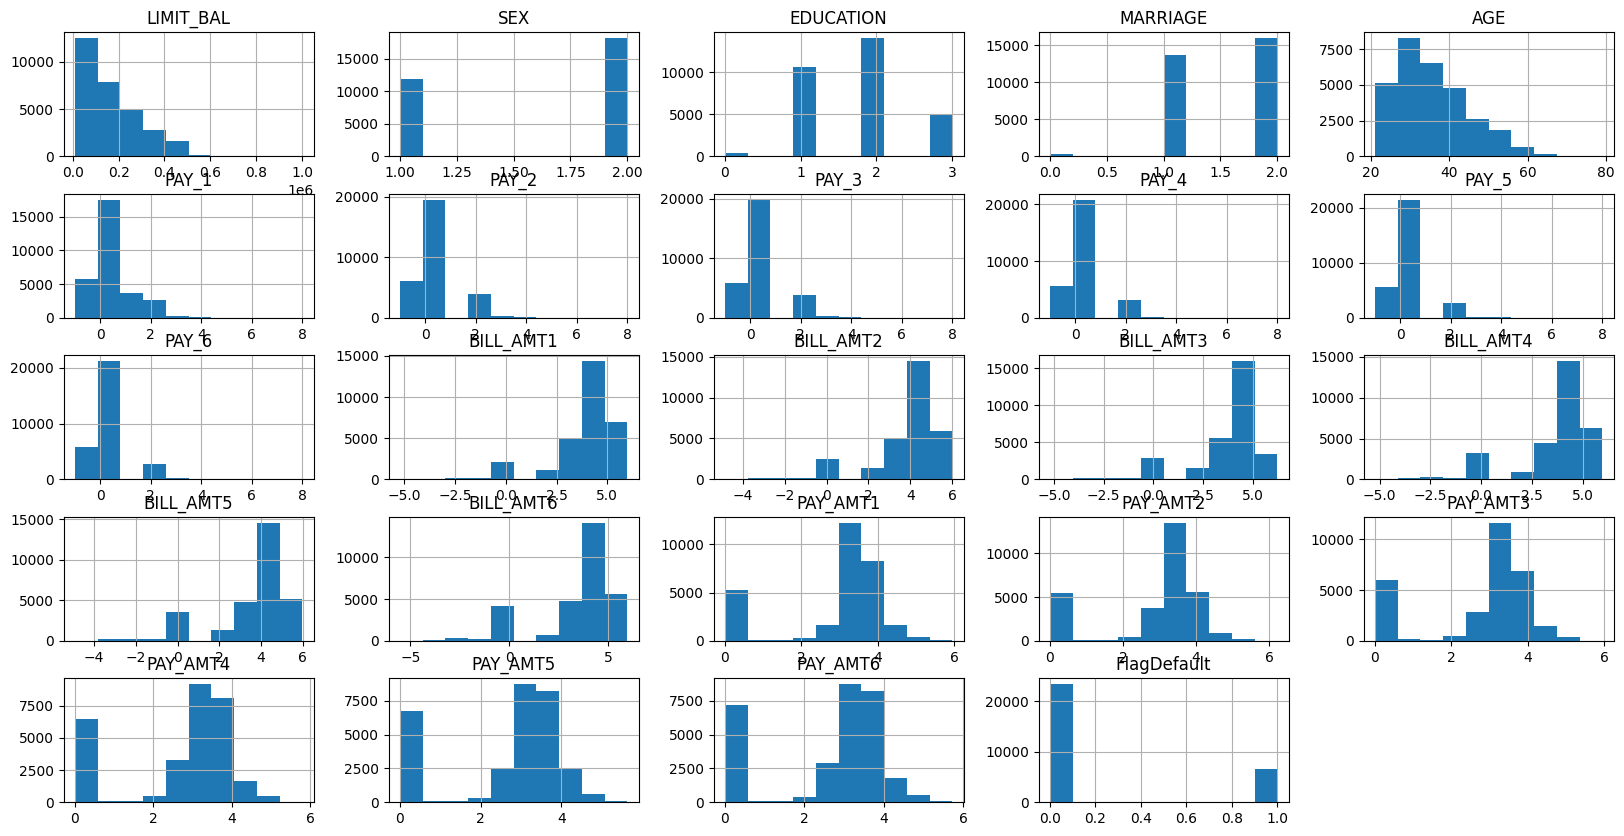

In [7]:
## Examine the data-- univariate distributions for each variable
_ = data.hist(figsize=(20, 10))

<Axes: >

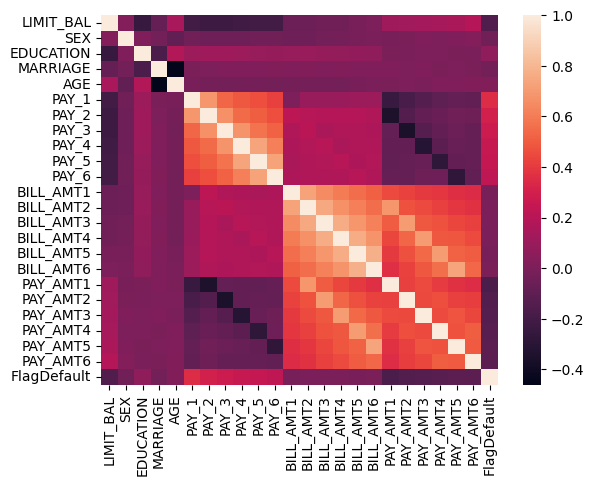

In [8]:
## Examine the pairwise correlation
sns.heatmap(data.corr())

In [9]:
## Select the variables
predictors = ['PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]
response = 'FlagDefault'
X= data[predictors]
Y= data[response]

In [10]:
## Prep the data-- Train/Test Split
train_x,  test_x, train_y, test_y  = train_test_split(X, Y, test_size=0.2, random_state=0)

In [11]:
## Small function to simplify calculating performance metrics
def check_perform(mod, x_train, y_train, x_test, y_test):
  yhat_train = mod.predict_proba(x_train)[:,1]
  yhat_test = mod.predict_proba(x_test)[:,1]
  res_df = pd.DataFrame(index=["AUC", "logloss"], columns=["train", "test"])
  res_df.loc["AUC", "train"] = round(roc_auc_score(y_train, yhat_train),4)
  res_df.loc["AUC", "test"] = round(roc_auc_score(y_test, yhat_test),4)
  res_df.loc["logloss", "train"] = round(log_loss(y_train, yhat_train),4)
  res_df.loc["logloss", "test"] = round(log_loss(y_test, yhat_test),4)
  return res_df

## Random Forest
Fit Random Forest Models

In [12]:
?RandomForestClassifier

In [13]:
## Fit a Random Forest Model with the default parameters:
rf1 = RandomForestClassifier()
rf1.fit(train_x, train_y)
check_perform(rf1, train_x, train_y, test_x, test_y)

,train,test
AUC,0.9991,0.764
logloss,0.1296,0.4803


In [14]:
## Fit a Random Forest model with some customized parameters
rf2 = RandomForestClassifier(n_estimators=50, criterion="log_loss",
                             max_depth=10, min_samples_leaf=20)
rf2.fit(train_x, train_y)
check_perform(rf2, train_x, train_y, test_x, test_y)

,train,test
AUC,0.8201,0.7767
logloss,0.4052,0.4224


# Gradient Boosting Examples
Fit some example gradient Boosting models.

### Basic Gradient Boosting

In [15]:
?GradientBoostingClassifier

In [16]:
## First, try the default HP values
gb1 = GradientBoostingClassifier()
gb1.fit(train_x, train_y)
check_perform(gb1, train_x, train_y, test_x, test_y)

,train,test
AUC,0.7973,0.7754
logloss,0.4186,0.4226


In [17]:
## Now, try some customized HP values
gb2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,
                                 min_samples_leaf=20)
gb2.fit(train_x, train_y)
check_perform(gb2, train_x, train_y, test_x, test_y)

,train,test
AUC,0.7852,0.7752
logloss,0.4265,0.4234


### XGBoost Examples

XGBoost is similar to the standard Gradient Boosting algorithm, with some additonal functionality.

In [18]:
## First, try the default HP values
xgb1 = XGBClassifier()
xgb1.fit(train_x, train_y)
check_perform(xgb1, train_x, train_y, test_x, test_y)

,train,test
AUC,0.9266,0.7583
logloss,0.3037,0.4411


In [19]:
## Now, try some customized HP values
xgb2 = XGBClassifier(n_estimators=50, learning_rate=0.05,
                                 max_depth=10, reg_lambda=5)
xgb2.fit(train_x, train_y)
check_perform(xgb2, train_x, train_y, test_x, test_y)

,train,test
AUC,0.8749,0.778
logloss,0.3718,0.4251


In [20]:
??XGBClassifier

## Hyperparameter Optimization

Let tune the hyperparametes using Grid Search, Random Search, and some sequential search as well.

We'll tune XGB models as an example.

### Grid Search

Using `GridSearchCV()`, we will tune an XGBoost model.

GridSearchCV reference:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [21]:
## Set the parameter space to search over
param_grid ={
    "n_estimators":[50, 100, 250],
    "max_depth":[3,4,5,8],
    "learning_rate":[0.05, 0.1],
    "reg_lambda":[0, 1, 5, 10]
}

In [22]:
%%time
xgb = XGBClassifier()
gs = GridSearchCV(xgb, param_grid, scoring='neg_log_loss',
                  cv=3, n_jobs=1, verbose=2)
gs.fit(train_x, train_y)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=0; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=0; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=0; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=1; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=1; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=1; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=5; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=5; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=5; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, reg_lambda=10; total time=   0.9s
[CV] END learning

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 4, 5, 8],
                         'n_estimators': [50, 100, 250],
                         'reg_lambda': [0, 1, 5, 10]},
             scoring='neg_log_loss', verbose=2)

In [23]:
## Look at the chosen model
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 10}

In [24]:
## Check the performance of the chosen model
check_perform(gs.best_estimator_, train_x, train_y, test_x, test_y)

,train,test
AUC,0.7933,0.7757
logloss,0.4219,0.4225


In [25]:
## Save the model to disk for future use
with open("piml/XGB1.pkl", "wb") as handle:
  pickle.dump(gs.best_estimator_, handle)

### Randomized Search

Using `RandomizedSearchCV()`, we will tune an XGBoost model.

RandomizedSearchCV reference:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

May need to reference scipy.stats for information on distributions, e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform

In [26]:
dist_dict = {
    "n_estimators":[50, 100, 200, 250],
    "max_depth":sps.randint(low=2, high=10),
    "learning_rate":sps.uniform(loc=0.025, scale=0.075),
    "reg_lambda":sps.uniform(loc=0, scale=15)
}

In [27]:
xgb = XGBClassifier()
rs = RandomizedSearchCV(xgb, dist_dict, n_iter=50, scoring='neg_log_loss',
                  cv=3, n_jobs=1, verbose=2, random_state=33)
rs.fit(train_x, train_y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.043638259557829746, max_depth=2, n_estimators=200, reg_lambda=6.164112044948112; total time=   2.4s
[CV] END learning_rate=0.043638259557829746, max_depth=2, n_estimators=200, reg_lambda=6.164112044948112; total time=   5.1s
[CV] END learning_rate=0.043638259557829746, max_depth=2, n_estimators=200, reg_lambda=6.164112044948112; total time=   2.3s
[CV] END learning_rate=0.04452247681651749, max_depth=8, n_estimators=100, reg_lambda=2.7755989074285745; total time=   4.9s
[CV] END learning_rate=0.04452247681651749, max_depth=8, n_estimators=100, reg_lambda=2.7755989074285745; total time=   7.7s
[CV] END learning_rate=0.04452247681651749, max_depth=8, n_estimators=100, reg_lambda=2.7755989074285745; total time=   5.0s
[CV] END learning_rate=0.0264746069072533, max_depth=7, n_estimators=250, reg_lambda=10.206762070965588; total time=  27.2s
[CV] END learning_rate=0.0264746069072533, max_depth=7, n_estima

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7900e2fcb2b0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7900e2fc9ed0>,
                                        'n_estimators': [50, 100, 200, 250],
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7900e2fcadd0>},
                   random_state=33, scoring='neg_log_loss', verbose=2)

In [28]:
## Look at the configuration of the best model
rs.best_params_

{'learning_rate': 0.029462074394909523,
 'max_depth': 4,
 'n_estimators': 250,
 'reg_lambda': 9.29663253008535}

In [29]:
## Check the performance
check_perform(rs.best_estimator_, train_x, train_y, test_x, test_y)

,train,test
AUC,0.7994,0.775
logloss,0.4172,0.4223


In [30]:
with open("piml/XGB2.pkl", "wb") as handle:
  pickle.dump(rs.best_estimator_, handle)

## Bayesian Search

Here we will demonstrate the use of the Bayesian Search functionality from the scikit-optimize package.

Reference: https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html



In [31]:
## Set up the search space
search_dict = {
    "n_estimators":[50, 100, 200, 250],
    "max_depth":(2, 10),
    "learning_rate":(0.025, 0.1, 'uniform'),
    "reg_lambda":(0.0, 15.0, 'uniform')
}

In [33]:
## Train and fit the model
xgb = XGBClassifier()
bs = BayesSearchCV(xgb, search_dict, n_iter=50, scoring='neg_log_loss',
                  cv=3, n_jobs=1, verbose=2, random_state=33)
bs.fit(train_x, train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.05817004858628673, max_depth=3, n_estimators=200, reg_lambda=8.261178080458317; total time=   7.4s
[CV] END learning_rate=0.05817004858628673, max_depth=3, n_estimators=200, reg_lambda=8.261178080458317; total time=   5.9s
[CV] END learning_rate=0.05817004858628673, max_depth=3, n_estimators=200, reg_lambda=8.261178080458317; total time=   3.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.06965453008115897, max_depth=7, n_estimators=50, reg_lambda=6.725182906298538; total time=   2.2s
[CV] END learning_rate=0.06965453008115897, max_depth=7, n_estimators=50, reg_lambda=6.725182906298538; total time=   4.9s
[CV] END learning_rate=0.06965453008115897, max_depth=7, n_estimators=50, reg_lambda=6.725182906298538; total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.09089850614302133, max_depth=10, n_estimators=100, reg_la

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, ...),
              random_state=33, scoring='neg_log_loss',
              search_spaces={'learning_rate': (0.025, 0.1, 'uniform'),
                             'max_depth': (2, 10),
                             'n_estimators': [50, 100, 200, 250],
                             'reg_lambda': (0.0, 15.0, 'uniform')},
              verbose=2)

In [34]:
## Look at the configuration of the best model
bs.best_params_

OrderedDict([('learning_rate', 0.05817004858628673),
             ('max_depth', 3),
             ('n_estimators', 200),
             ('reg_lambda', 8.261178080458317)])

In [35]:
## Check the performance
check_perform(bs.best_estimator_, train_x, train_y, test_x, test_y)

,train,test
AUC,0.7963,0.776
logloss,0.42,0.4224


In [36]:
## Save this model for reference
with open("piml/XGB3.pkl", "wb") as handle:
  pickle.dump(bs.best_estimator_, handle)